In [75]:
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import os
from scipy.optimize import curve_fit

In [76]:
def import_data():
    def empty_dict():
        return(defaultdict(empty_dict))
    data = defaultdict(empty_dict)
    
    for dir in os.listdir("./data_18_11/"):
        for file in os.listdir("./data_18_11/" + dir):
            if os.path.isfile("./data_18_11/" +dir +"/" +file) == True:
                with open("./data_18_11/"+dir+"/"+file) as f:
                    new_data = json.load(f)
                    for distance in new_data['data']:
                        data[new_data['bias']][distance] = new_data['data'][distance]
    return(data)

data = import_data()

## Functions for calculating thresholds and plotting

In [77]:
def threshold_fit(variables, B0, B1, B2, mu, pth):
    p, L = variables
    return(B0 + B1*(p-pth)*pow(L, 1/mu) + B2*pow((p-pth) * pow(L, 1/mu), 2))


def plot_per_vs_ler(per_array, ler_per_distances, ler_eb_per_distances, labels):
    for index,ler_per_distance in enumerate(ler_per_distances):
        for distance in ler_per_distance:
            plt.errorbar(per_array, ler_per_distance[distance], yerr=ler_eb_per_distances[index]
                         [distance], label='d = ' + str(distance) + str(labels[index]))
    plt.legend()
    plt.yscale("log")
    plt.xlabel("physical error rate")
    plt.ylabel("logical error rate")

def plot_ler_vs_distance(code_dict, per, code_label,marker_style,line_style,colour,ax):
    distances = []
    ler = []
    ler_eb = []
    n_qubits = []
    for distance in code_dict:
        if distance.isinstance(str):
            if int(distance) in [5, 7, 9, 13, 17, 21]:
                distances.append(int(distance))


    distances.sort()
    for distance in distances:
        if str(per) in code_dict[str(distance)].keys(): 
            if code_dict[str(distance)][str(per)]['total_run_count_all_models'] > 50:
                ler.append(code_dict[str(distance)][str(per)]['ler']/code_dict[str(distance)][str(per)]['total_run_count_all_models'])
                ler_eb.append(np.sqrt(
                    (1-ler[-1])*ler[-1]/code_dict[str(distance)][str(per)]['run_count']))
                n_qubits.append(np.sqrt(code_dict[str(distance)]["N"]))
    ax.errorbar(n_qubits, ler, label=code_label, yerr=ler_eb,marker=marker_style,linestyle=line_style,color=colour, linewidth=4,markersize=18)

    ax.set_yscale('log')
    ax.legend(loc='lower left', prop={'size': 24})
    ax.set_ylabel('Logical failure rate', size=28)
    ax.set_xlabel('Code distance $\it{d}$', size=28)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', direction='out', length=18, width=2, colors='black', grid_color='black', grid_alpha=1)
    ax.tick_params(axis='both', which='minor', direction='out', length=9, width=2, colors='black', grid_color='black', grid_alpha=1)
        
def calculate_threshold(code_dict, min_distance=1, max_distance=100, distances= None,min_per=None, max_per=None, title=None, ax=None, calculate_threshold=True, non_uniform=False):
    ler_data = []
    ler_eb_data = []
    per_data = []
    distance_data = []
    for distance in code_dict:
        if distances == None:
            if int(distance) > min_distance and int(distance) < max_distance:
            
                per_array = code_dict[distance]["per"]
                ler_array = code_dict[distance]["ler"]
                ler_eb = code_dict[distance]["ler_eb"]
                per_data.extend(per_array)
                ler_data.extend(ler_array)
                ler_eb_data.extend(ler_eb)
                distance_data.extend([int(distance) for _ in range(len(per_array))])
        elif int(distance) in distances:
            per_array = code_dict[distance]["per"]
            ler_array = code_dict[distance]["ler"]
            ler_eb = code_dict[distance]["ler_eb"]

            per_data.extend(per_array)
            ler_data.extend(ler_array)
            ler_eb_data.extend(ler_eb)
            distance_data.extend([int(distance) for _ in range(len(per_array))])

    if calculate_threshold:
        popt, pcov = curve_fit(threshold_fit, (per_data, distance_data),
                                ler_data ,maxfev=5000) 
        if ax !=None:
            ax.axvline(x = popt[-1], color = 'black', linestyle = 'dashed')
        error = np.sqrt(np.diag(pcov))[-1]

    distance_array = []
    for distance in code_dict:
        if distances == None:
            if int(distance) > min_distance and int(distance) < max_distance:
                        distance_array.append(int(distance))
        elif int(distance) in distances:
            distance_array.append(int(distance))
    distance_array.sort()
    for distance in distance_array:

        per_array = code_dict[str(distance)]['per']
        ler_array = code_dict[str(distance)]["ler"]
        ler_eb = code_dict[str(distance)]["ler_eb"]

        if per_array != []:
            if ax != None:
                ax.errorbar(per_array,ler_array,yerr=ler_eb,label = 'd = ' + str(distance), fmt = 'o')   

        if calculate_threshold:
            if ax != None:
                ax.plot(per_array, threshold_fit(
                    (per_array, [int(distance) for _ in range(len(per_array))]), *popt), color='grey')

    if ax != None:
        ax.legend()
        ax.set_xlabel('physical error rate')
        ax.set_ylabel('logical error rate')
        ax.set_title(title)

    if calculate_threshold:
        return(popt[-1], error)


# Calculation and plots of thresholds at different biases. 
I use distances 13,19,25 as these together have higher thresholds than 9,15,21,27 and 11,7,23,29 (see plots at the end for a verification of this)

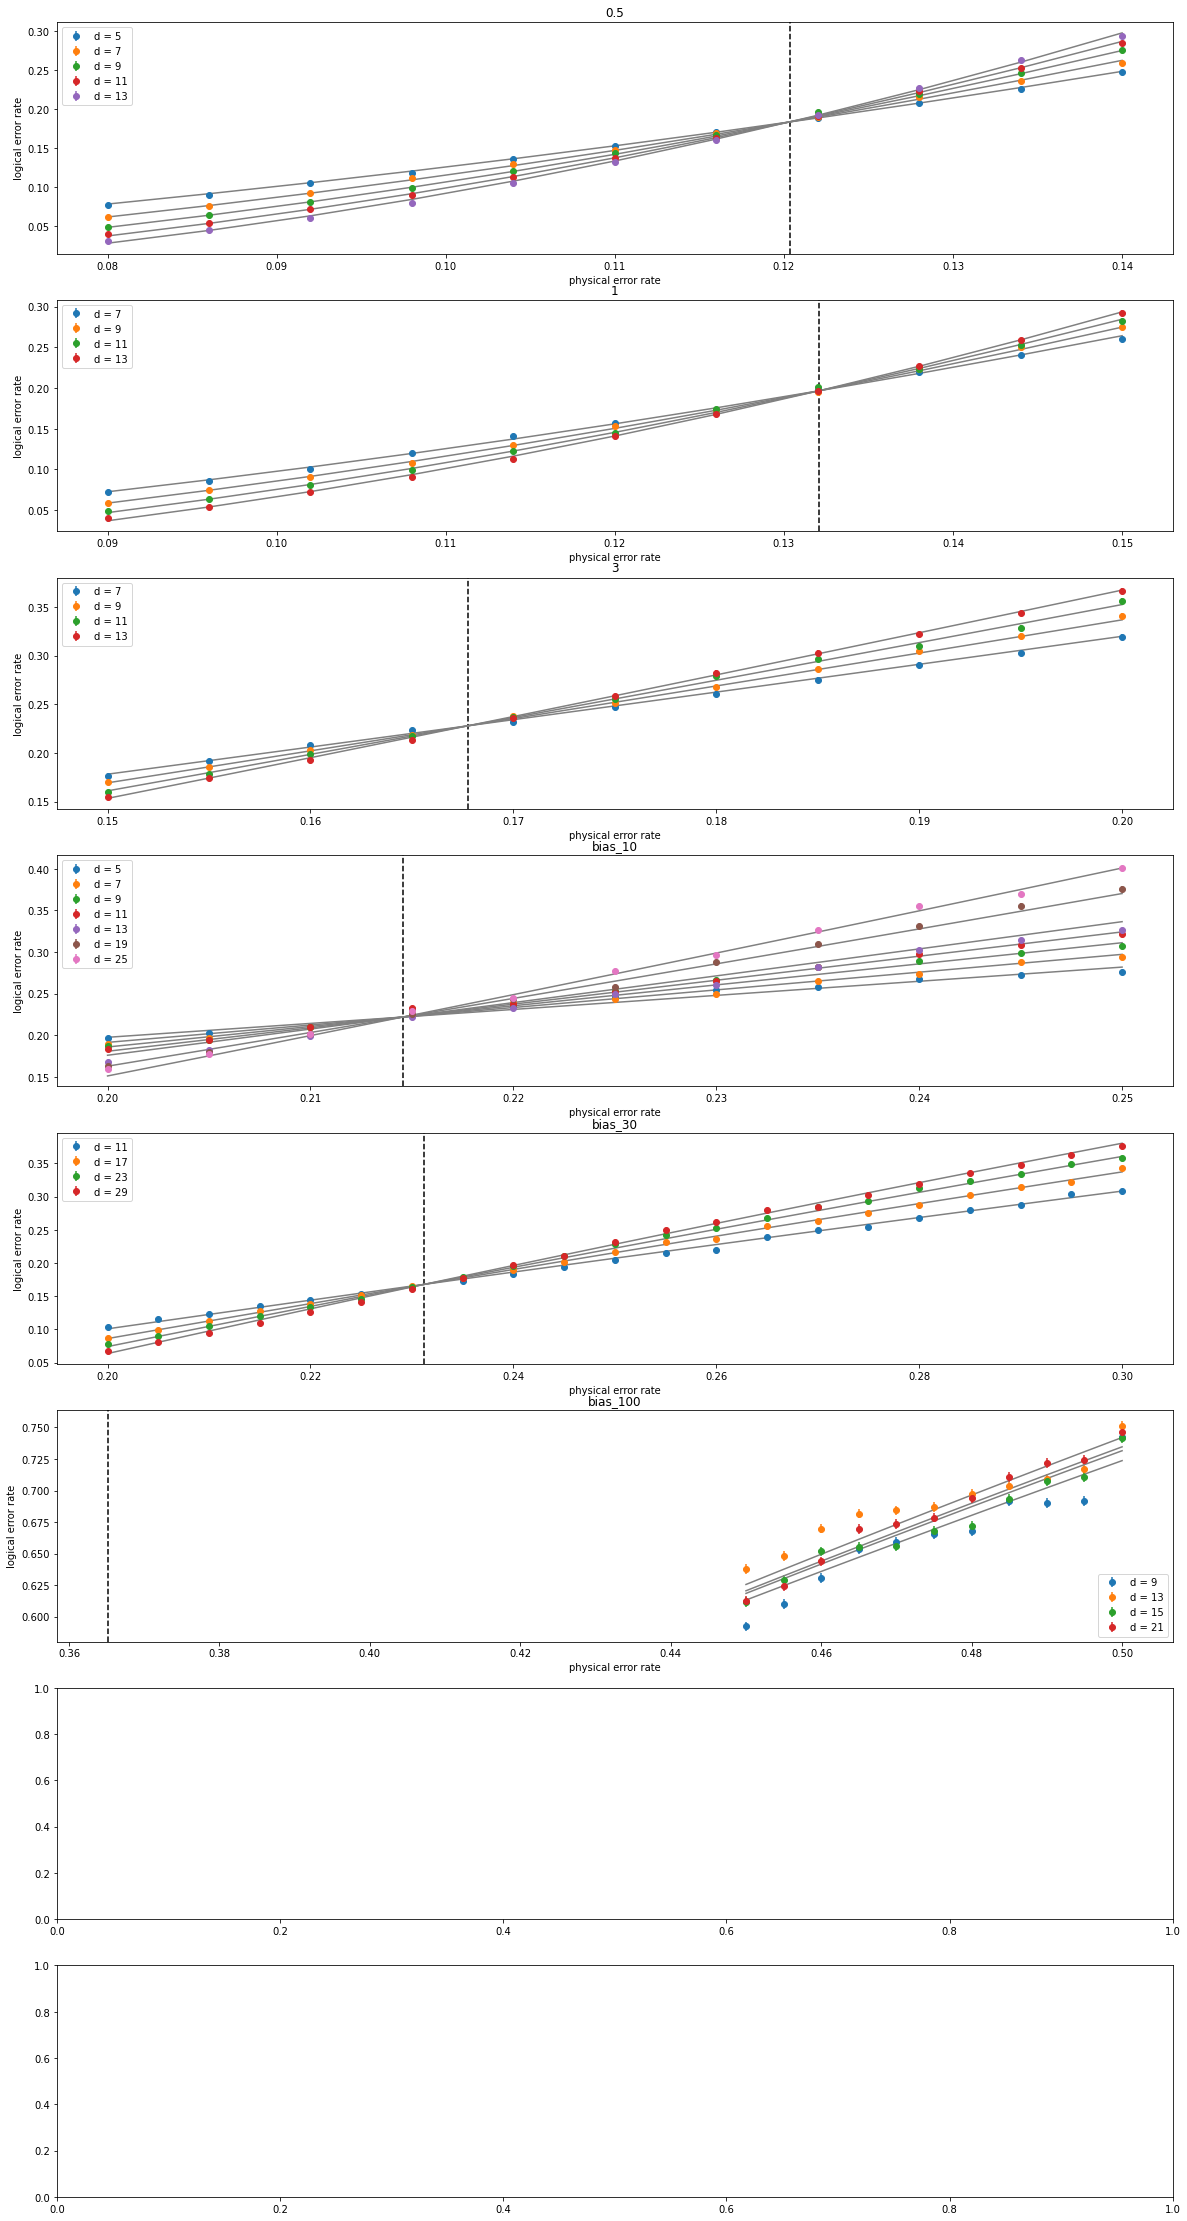

In [84]:
fig, axs = plt.subplots(nrows=8,figsize=(20,40))
thresholds = dict()

thresholds[0.5] = calculate_threshold(data[0.5],ax=axs[0],title='0.5',min_distance=4, max_distance=100,calculate_threshold=True)
thresholds[1] = calculate_threshold(data[1],ax=axs[1],title='1',min_distance=5, max_distance=100,calculate_threshold=True)
thresholds[3] = calculate_threshold(data[3],ax=axs[2],title='3',min_distance=5, max_distance=100,calculate_threshold=True)
thresholds[10]=calculate_threshold(data[10],ax=axs[3],title='bias_' + str(10),calculate_threshold=True)
thresholds[30] = calculate_threshold(data[30],ax=axs[4],title='bias_' + str(30),distances=[11,17,23,29],calculate_threshold=True)
thresholds[100] = calculate_threshold(data[100],ax=axs[5],title='bias_' + str(100),distances=[9,13,15,21],calculate_threshold=True)
#thresholds[300] = calculate_threshold(data[300],ax=axs[6],title='bias_' + str(300),distances = [13,19,25],calculate_threshold=True)
#thresholds[1000] = calculate_threshold(data[1000],ax=axs[7],title='bias_' + str(1000),distances = [7,13,19,25],calculate_threshold=False)


# Threshold vs bias plot

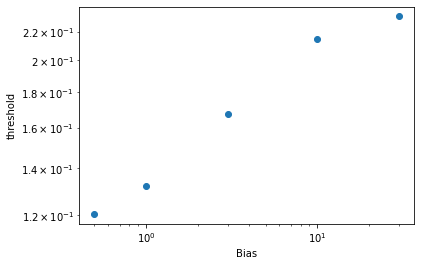

In [53]:
biases = list(thresholds.keys())
threshold_plot= [thres[0] for thres in  thresholds.values()]

plt.plot(biases, threshold_plot,'o')
plt.xlabel('Bias')
plt.ylabel('threshold')
plt.loglog()
plt.savefig('thresholdvsbias.png')
plt.show()


# Plots I used to check the different thresholds at bias 10 and 30

None


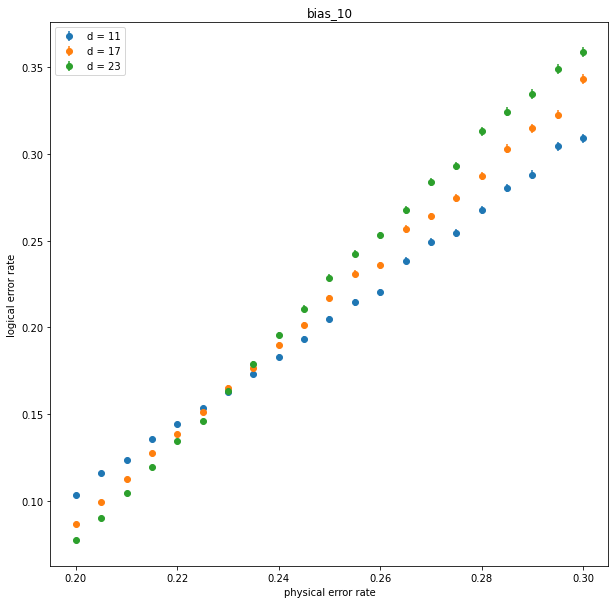

In [11]:
fig, axs = plt.subplots(figsize=(10,10))
thresholds = []
biases = list(data.keys())
biases.sort()
#print(calculate_threshold(data[10],ax=axs,title='bias_' + str(10),distances = [3,5,7,9],calculate_threshold=False))
#print(calculate_threshold(data[10],ax=axs,title='bias_' + str(10),distances = [9,15,21],calculate_threshold=True))
#print(calculate_threshold(data[10],ax=axs,title='bias_' + str(10),distances = [11,17,23,29],calculate_threshold=True))
print(calculate_threshold(data[30],ax=axs,title='bias_' + str(10),distances = [11,17,23],calculate_threshold=False))


(0.3907888106123908, 0.008499623291450006)
(0.38319647827102477, 0.007661191511914724)
(0.4292682197911813, 0.004166830097926958)


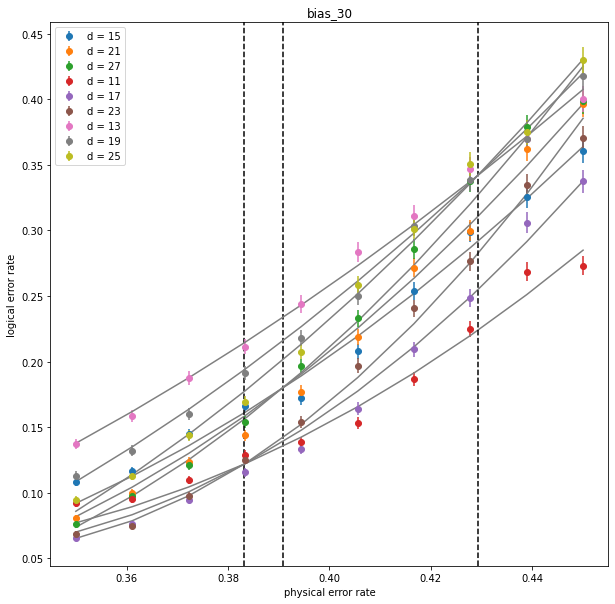

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
thresholds = []
biases = list(data.keys())
biases.sort()
print(calculate_threshold(data[30],ax=axs,title='bias_' + str(30), distances=[9,15,21,27],calculate_threshold=True))
print(calculate_threshold(data[30],ax=axs,title='bias_' + str(30),distances=[11,17,23],calculate_threshold=True))
print(calculate_threshold(data[30],ax=axs,title='bias_' + str(30),distances=[13,19,25],calculate_threshold=True))



(0.31834904049767265, 0.01088870077655589)

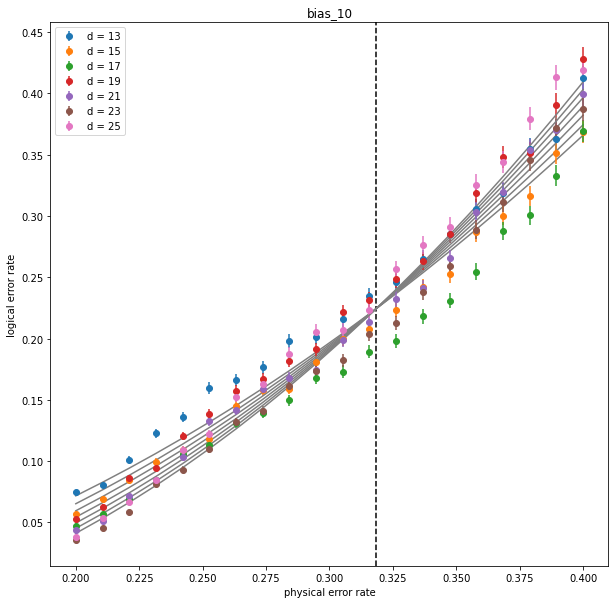

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
thresholds = []
biases = list(data.keys())
biases.sort()
calculate_threshold(data[10],ax=axs, min_distance=12,title='bias_' + str(10),calculate_threshold=True)

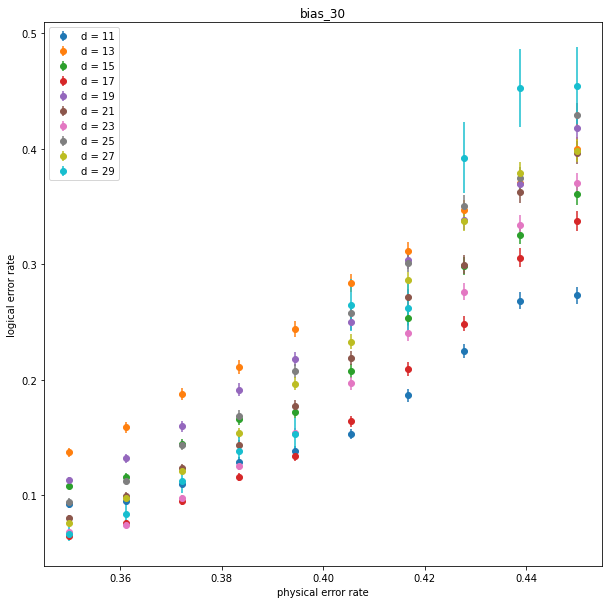

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
#subplot_mosaic(len(),
#                              constrained_layout=True, figsize = (15,15))
thresholds = []
biases = list(data.keys())
biases.sort()
#for index,bias in enumerate(biases):
calculate_threshold(data[30],ax=axs,title='bias_' + str(30),min_distance=1, max_distance=100,calculate_threshold=False)

(0.3907888106123908, 0.008499623291450006)

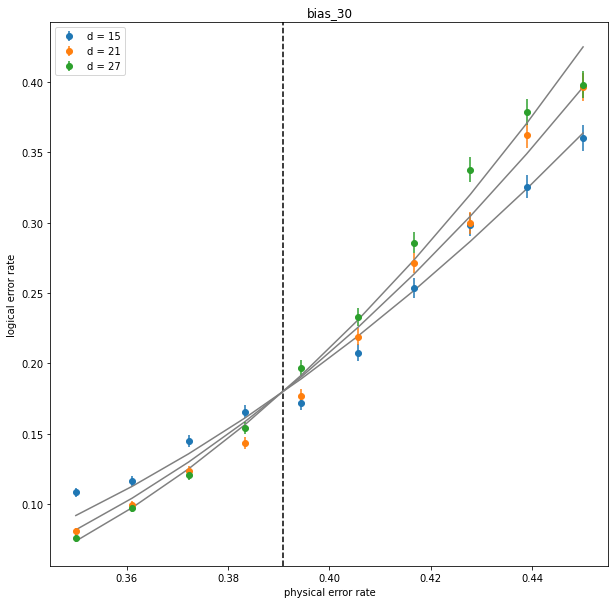

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
#subplot_mosaic(len(),
#                              constrained_layout=True, figsize = (15,15))
thresholds = []
biases = list(data.keys())
biases.sort()
#for index,bias in enumerate(biases):
calculate_threshold(data[30],ax=axs,title='bias_' + str(30),distances=[9,15,21,27],min_distance=1, max_distance=100,calculate_threshold=True)

(0.3719687000892226, 0.00944990066097504)

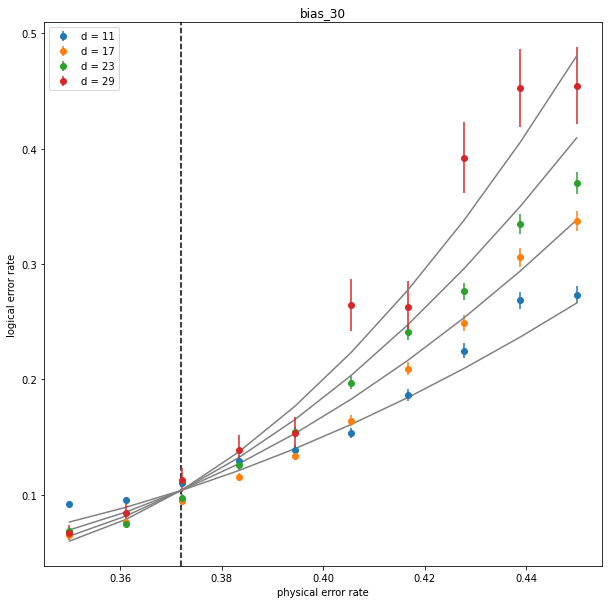

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
#subplot_mosaic(len(),
#                              constrained_layout=True, figsize = (15,15))
thresholds = []
biases = list(data.keys())
biases.sort()
#for index,bias in enumerate(biases):
calculate_threshold(data[30],ax=axs,title='bias_' + str(30),distances=[11,17,23,29],min_distance=1, max_distance=100,calculate_threshold=True)

(0.4292682197911813, 0.004166830097926958)

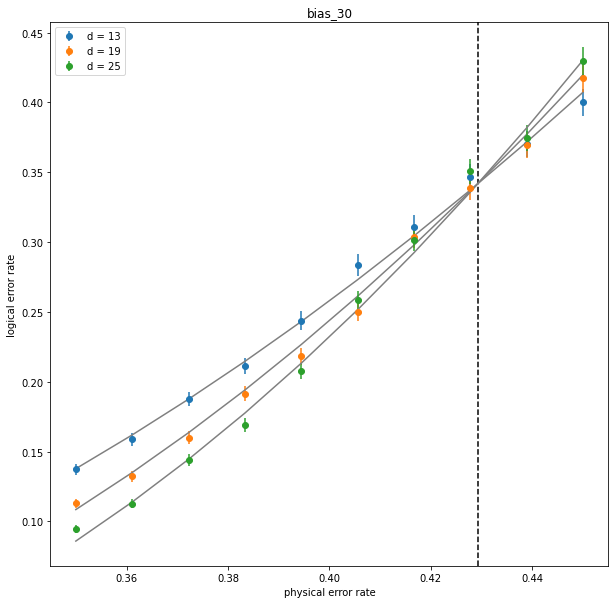

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
#subplot_mosaic(len(),
#                              constrained_layout=True, figsize = (15,15))
thresholds = []
biases = list(data.keys())
biases.sort()
#for index,bias in enumerate(biases):
calculate_threshold(data[30],ax=axs,title='bias_' + str(30),distances=[13,19,25],min_distance=1, max_distance=100,calculate_threshold=True)

(0.3992192519506216, 0.011140357415868309)

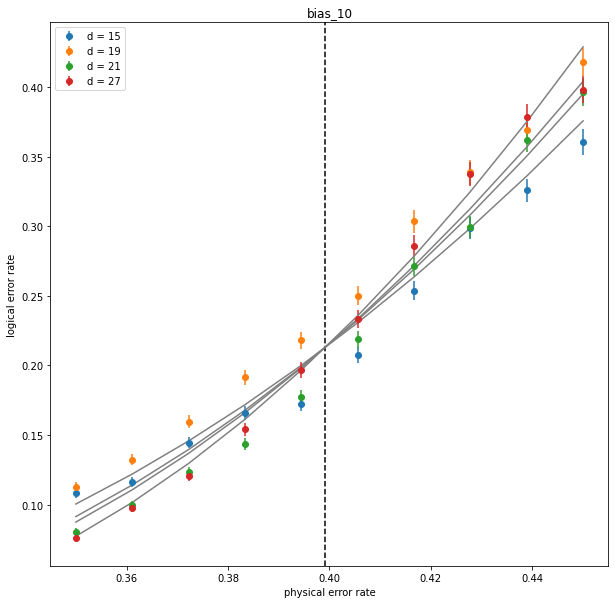

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
#subplot_mosaic(len(),
#                              constrained_layout=True, figsize = (15,15))
thresholds = []
biases = list(data.keys())
biases.sort()
#for index,bias in enumerate(biases):
calculate_threshold(data[30],ax=axs,title='bias_' + str(10),distances=[9,15,19,21,27],min_per=0.35,min_distance=1, max_distance=100,calculate_threshold=True)

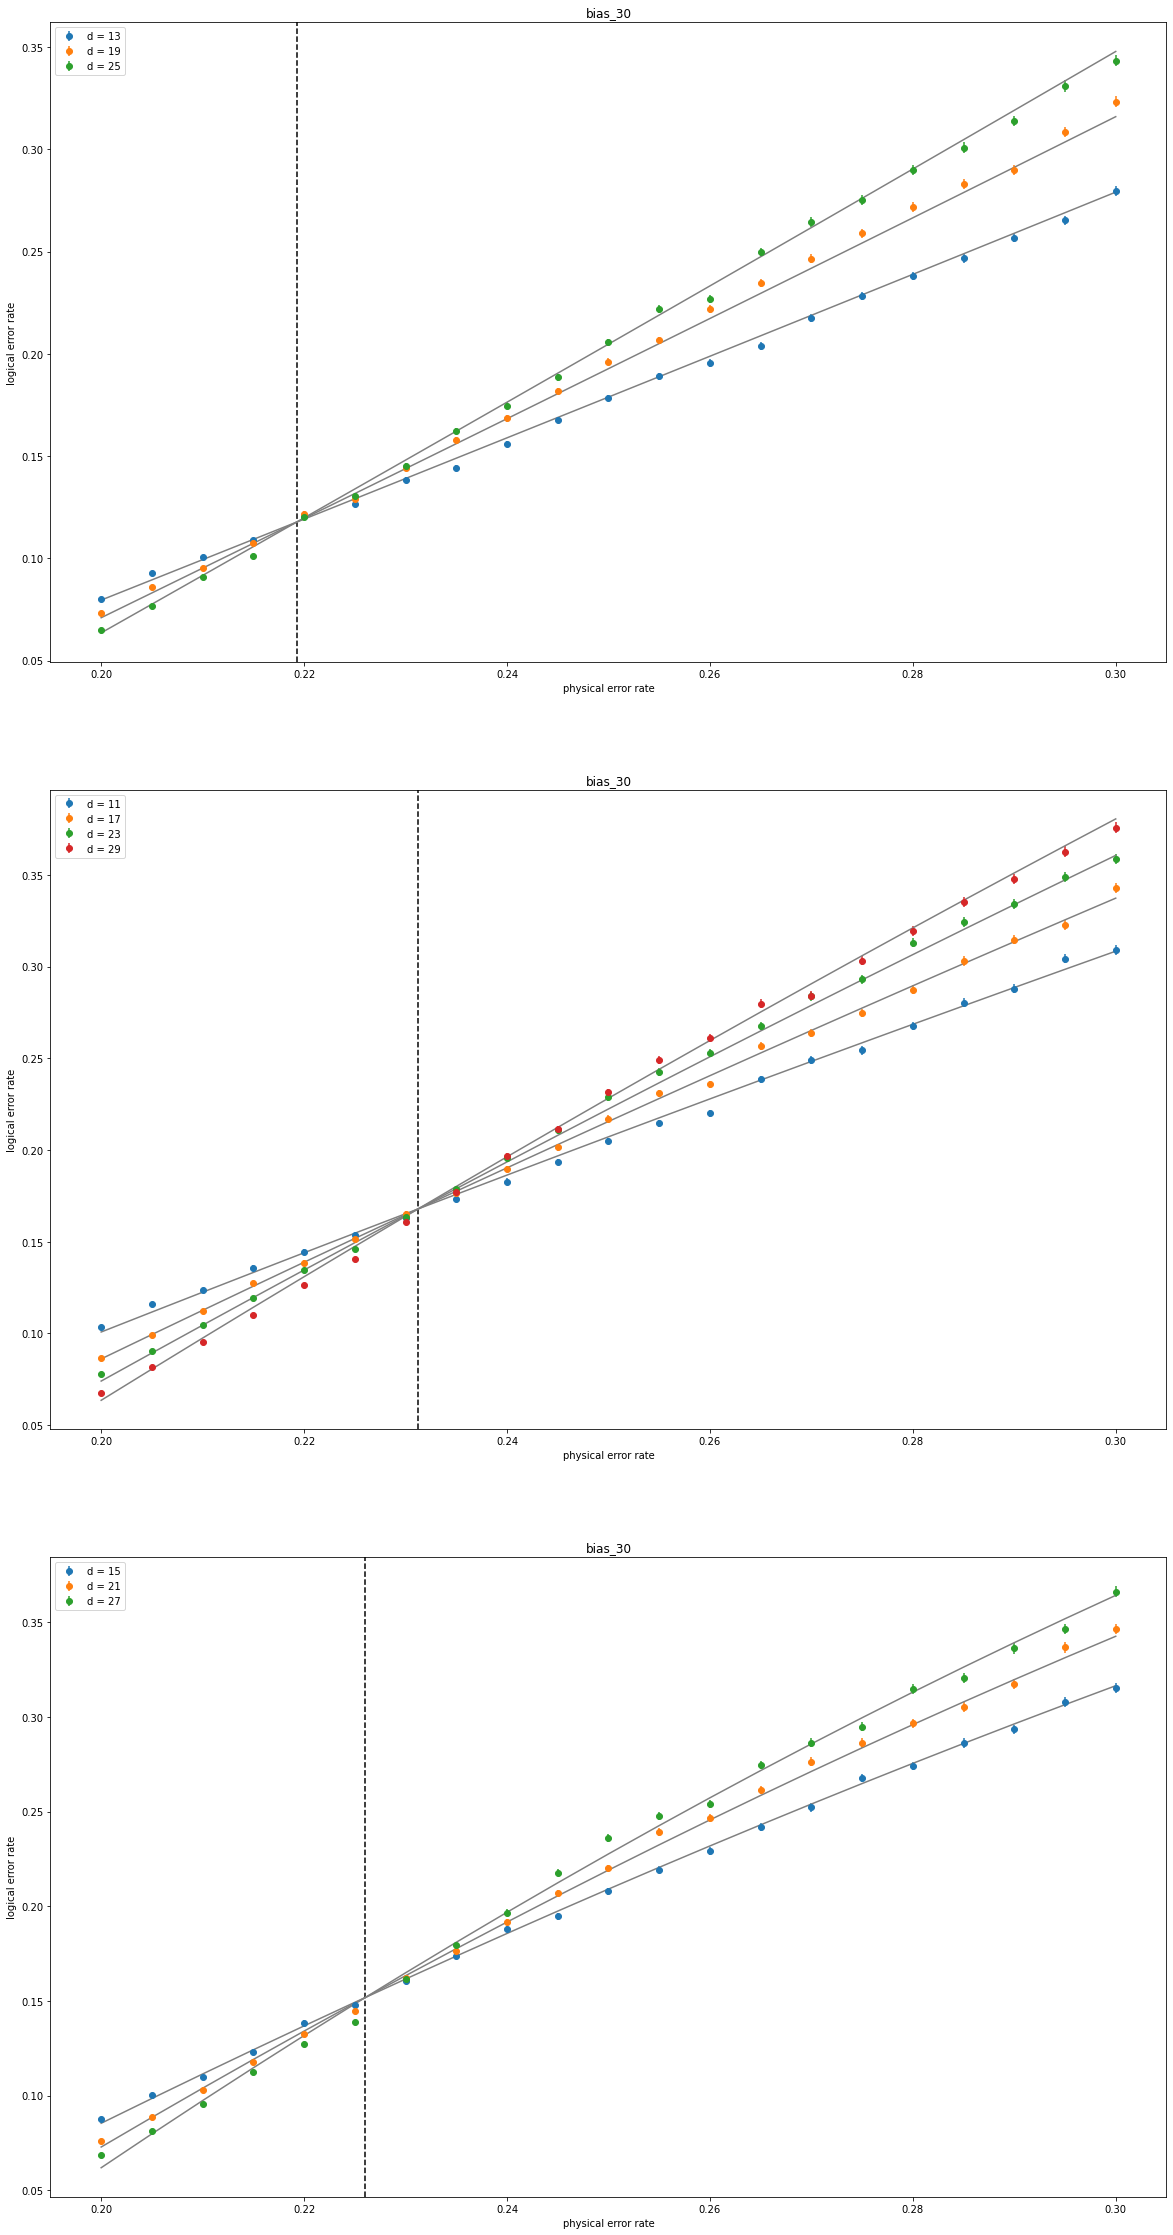

In [86]:
fig, axs = plt.subplots(nrows=3,figsize=(20,40))
thresholds = dict()
thresholds[30] = calculate_threshold(data[30],ax=axs[0],title='bias_' + str(30),distances=[7,13,19,25],calculate_threshold=True)
thresholds[30] = calculate_threshold(data[30],ax=axs[1],title='bias_' + str(30),distances=[11,17,23,29],calculate_threshold=True)
thresholds[30] = calculate_threshold(data[30],ax=axs[2],title='bias_' + str(30),distances=[15,21,27],calculate_threshold=True)